In [43]:
import os
from tqdm.auto import tqdm
from datetime import time
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import sys
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
print(sys.path)
import random
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

['c:\\Users\\gaura\\PycharmProjects\\scientificProject', 'c:\\Program Files\\Python311\\python311.zip', 'c:\\Program Files\\Python311\\DLLs', 'c:\\Program Files\\Python311\\Lib', 'c:\\Program Files\\Python311', '', 'C:\\Users\\gaura\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\gaura\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\gaura\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\gaura\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Program Files\\Python311\\Lib\\site-packages']


In [44]:
# # !pip install wandb
# import wandb
# wandb.login(key = "d4c2dc0cbf8caf1ee8dc1563f3d5c10594df22b5")
# wandb.init(project="DL_ASSIGNMENT_3_with_attention")




In [45]:
# %env WANDB_SILENT=true
# wandb.init(timeout=300)

In [46]:



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Executing on " + ("cuda:0" if torch.cuda.is_available() else "cpu"))

if 'PYTHONPATH' in os.environ:
    if 'kaggle' in os.environ['PYTHONPATH']:
        print('Running on Kaggle')
        df_train = pd.read_csv("/kaggle/input/aksharantar_sampled/aksharantar_sampled/mar/mar_train.csv")
        df_test = pd.read_csv('/kaggle/input/aksharantar_sampled/aksharantar_sampled/mar/mar_test.csv')
        df_valid = pd.read_csv('/kaggle/input/aksharantar/aksharantar_sampled/mar/mar_valid.csv')
else:
    #change the path to Data/mar
    print('Running on local')
    df_train = pd.read_csv("Data/mar/mar_train.csv")
    df_test = pd.read_csv('Data/mar/mar_test.csv')
    df_valid = pd.read_csv('Data/mar/mar_valid.csv')

print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

PAD_CHAR = '_'  # padding character
EOW_CHAR = '|'  # end of word character
SOW_CHAR = '$'  # start of word character
BATCH_SIZE = 32
ENGLISH_ALPHA = [chr(alpha) for alpha in range(ord('a'), ord('z') + 1)]
INPUT_CHAR_INDX = {PAD_CHAR: 0, EOW_CHAR: 1, SOW_CHAR: 2}
for index, alpha in enumerate(ENGLISH_ALPHA):
    INPUT_CHAR_INDX[alpha] = index + 3

INPUT_INDX_CHAR = {v: k for k, v in INPUT_CHAR_INDX.items()}

df_train = df_train.set_axis(['X', 'Y'], axis=1)
df_valid = df_valid.set_axis(['X', 'Y'], axis=1)
df_test = df_test.set_axis(['X', 'Y'], axis=1)

print(INPUT_CHAR_INDX)

ouput_words = df_train['Y'].tolist() + df_test['Y'].tolist() + df_valid['Y'].tolist()
output_char_set = set()
for word in ouput_words:
    for char in word:
        output_char_set.add(char)
OUT_ALPHA = list(output_char_set)
# OUT_ALPHA = [chr(alpha) for alpha in range(2304, 2432)]
OUT_ALPHA_SIZE = len(OUT_ALPHA)
OUTPUT_CHAR_INDEX = {PAD_CHAR: 0, EOW_CHAR: 1, SOW_CHAR: 2}
for index, alpha in enumerate(OUT_ALPHA):
    OUTPUT_CHAR_INDEX[alpha] = index + 3
# %%

OUTPUT_INDEX_CHAR = {v: k for k, v in OUTPUT_CHAR_INDEX.items()}

print("ouput char set ",output_char_set)
print("ouput char set size",len(output_char_set))

OUTPUT_INDEX_CHAR = {v: k for k, v in OUTPUT_CHAR_INDEX.items()}

# print(OUTPUT_CHAR_INDEX)
# print(len(OUTPUT_CHAR_INDEX))

df_train = df_train.set_axis(['X', 'Y'], axis=1)
df_valid = df_valid.set_axis(['X', 'Y'], axis=1)
df_test = df_test.set_axis(['X', 'Y'], axis=1)
# %%
# print(df_train)
# print(df_test)
# print(df_valid)

if 'kaggle' not in sys.path:
    df_train = df_train.iloc[:2000,:]
    df_test = df_test.iloc[:200,:]
    df_valid = df_valid.iloc[:200,:]

# %%
max_input_length = max(df_train.iloc[:, 0].apply(lambda x: len(x)).max(),
                       df_test.iloc[:, 0].apply(lambda x: len(x)).max(),
                       df_valid.iloc[:, 0].apply(lambda x: len(x)).max())

max_output_length = max(df_train.iloc[:, 1].apply(lambda x: len(x)).max(),
                        df_test.iloc[:, 1].apply(lambda x: len(x)).max(),
                        df_valid.iloc[:, 1].apply(lambda x: len(x)).max())

print("max input length", max_input_length)
print("max output length", max_output_length)
MAX_LENGTH = max(max_input_length, max_output_length)
print("max_length", MAX_LENGTH)
# %%
input_vocab_size = len(INPUT_CHAR_INDX)
output_vocab_size = len(OUTPUT_CHAR_INDEX)
print("Input Character max", input_vocab_size)
print("output Character size", output_vocab_size)

train_list = df_train.values.tolist()
valid_list = df_valid.values.tolist()
test_list = df_test.values.tolist()

# %%
input_vocab_size = len(INPUT_CHAR_INDX)
output_vocab_size = len(OUTPUT_CHAR_INDEX)
print("Input Character max", input_vocab_size)
print("output Character size", output_vocab_size)

train_list = df_train.values.tolist()
valid_list = df_valid.values.tolist()
test_list = df_test.values.tolist()


# %% md
class Transliterate(Dataset):
    def __init__(self, df_data, in_dict, out_dict):
        super().__init__()
        self.df_data_word = df_data.copy()
        self.in_dict = in_dict
        self.out_dict = out_dict
        self.df_data = df_data.iloc[:, ].apply(lambda x: SOW_CHAR + x + EOW_CHAR)


    def __get_random_word__(self):
        idx = random.randint(0, len(self.df_data))
        input_word = self.df_data_word.iloc[idx][0]
        output_word = self.df_data_word.iloc[idx][1]
        return input_word, output_word

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        input_word = self.df_data.iloc[idx][0]
        output_word = self.df_data.iloc[idx][1]
        input_tensor = inputToTensor(input_word)
        output_tensor = outToTensor(output_word)
        return input_tensor, output_tensor

    def __getrandom__(self):
        idx = random.randint(0,len(self.data_list))
        input_word = self.df_data[idx][0]
        output_word = self.df_data[idx][1]
        input_tensor = inputToTensor(input_word)
        output_tensor = outToTensor(output_word)
        return input_tensor, output_tensor

    def preprocess(self, word):
        return SOW_CHAR + word + EOW_CHAR


train_data = Transliterate(df_train, INPUT_CHAR_INDX, OUTPUT_CHAR_INDEX)
valid_data = Transliterate(df_valid, INPUT_CHAR_INDX, OUTPUT_CHAR_INDEX)
test_data = Transliterate(df_test, INPUT_CHAR_INDX, OUTPUT_CHAR_INDEX)
# %%
def inputToTensor(line):
    tensor = torch.tensor(data=([INPUT_CHAR_INDX[x] for x in line]), dtype=torch.long)
    return tensor


def charToTensor(char, dic=INPUT_CHAR_INDX):
    tensor = torch.zeros(len(dic))
    tensor[dic[char]] = 1
    return tensor


def outToTensor(word):
    tensor = torch.tensor([OUTPUT_CHAR_INDEX[x] for x in word])
    return tensor


# %%
print(inputToTensor(train_list[0][0]))
# %%
print(train_list[1][1])

# %%
inputToTensor("$bindhya|")
# %%
print(INPUT_CHAR_INDX)
# %%
print(inputToTensor("hello"))


# %%
def generate_batch(data_batch):
    train_batch = [x[0] for x in data_batch]
    target_batch = [x[1] for x in data_batch]
    train_pad = torch.nn.utils.rnn.pad_sequence(train_batch, batch_first=True, padding_value=0)
    train_pad = train_pad[:, :MAX_LENGTH]
    train_pad = torch.nn.functional.pad(train_pad, (0, MAX_LENGTH - train_pad.size(1)), value=0)
    target_pad = torch.nn.utils.rnn.pad_sequence(target_batch, batch_first=True, padding_value=0)
    target_pad = target_pad[:, :MAX_LENGTH]
    target_pad = torch.nn.functional.pad(target_pad, (0, MAX_LENGTH - target_pad.size(1)), value=0)
    padded_input_batch = train_pad.T.to(device)
    padded_output_batch = target_pad.T.to(device)
    return padded_input_batch, padded_output_batch




# for data, target in train_dataloader:
#     print(data.shape)
#     print(target.shape)
#     if True:
#         break


Executing on cpu
Running on local
(51199, 2)
(4095, 2)
(4095, 2)
{'_': 0, '|': 1, '$': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
ouput char set  {'ए', 'र', 'ॉ', 'व', 'फ', 'क', 'थ', 'ऱ', 'इ', 'ऍ', 'म', 'ु', 'घ', 'ब', 'छ', 'ी', 'ँ', 'च', 'प', 'ण', 'ृ', '्', 'श', 'े', 'ः', 'ल', 'द', 'भ', 'ढ', 'ई', 'आ', 'झ', 'ठ', 'उ', 'ळ', 'ौ', 'ऐ', 'ॅ', 'ओ', 'ञ', 'औ', 'ऋ', 'ि', 'ज', '़', 'ं', 'ा', 'न', 'ध', 'त', 'ड', 'ो', 'ह', 'स', 'ू', 'ट', 'ख', 'अ', 'य', 'ऊ', 'ष', 'ऑ', 'ग', 'ै'}
ouput char set size 64
max input length 25
max output length 19
max_length 25
Input Character max 29
output Character size 67
Input Character max 29
output Character size 67
tensor([ 4, 10, 23, 14, 22, 10,  3, 18,  3, 16,  3])
व्हायकी
{'_': 0, '|': 1, '$': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k'

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout, cell_type, bidirectional=True,
                 batch_size=BATCH_SIZE):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.cell_type = cell_type
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        if cell_type == 'RNN':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        # self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, hidden=None):
        self.batch_size = src.shape[1]
        embedded = self.dropout(self.embedding(src))
        if self.cell_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded, hidden)
        if self.bidirectional:
            # Split hidden and cell into two halves along the first dimension
            hidden_chunks = torch.chunk(hidden, 2, dim=0)
            hidden = 0.5 * (hidden_chunks[0] + hidden_chunks[1])

            if self.cell_type == "LSTM":
                cell_chunks = torch.chunk(cell, 2, dim=0)
                cell = 0.5 * (cell_chunks[0] + cell_chunks[1])

            # Compute the average of forward and backward outputs
            output = output.permute(2, 1, 0)
            output_chunks = torch.chunk(output, 2, dim=0)
            output = 0.5 * (output_chunks[0] + output_chunks[1])
            output = output.permute(2, 1, 0)

        if (self.cell_type == "LSTM"):
            return output, hidden, cell
        else:
            return output, hidden

    def initHidden(self):
        if self.bidirectional == True:
            return torch.zeros(2 * self.num_layers, self.batch_size, self.hidden_size, device=device)
        else:
            return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, device=device)


# write decoder with attention


class Decoder_with_attention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout, embedding_size, cell_type="LSTM",
                 batch_size=BATCH_SIZE):
        super(Decoder_with_attention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.cell_type = cell_type
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(self.hidden_size + self.embedding_size, MAX_LENGTH)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(dropout)
        if cell_type == 'RNN':
            self.rnn = nn.RNN(self.hidden_size, self.hidden_size, num_layers, dropout=dropout)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, num_layers, dropout=dropout)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(self.hidden_size, self.hidden_size, num_layers, dropout=dropout)

        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):

        input = input.unsqueeze(0)
        self.batch_size = input.size(1)
        output = self.embedding(input).view(-1, self.batch_size, self.embedding_size)
        output = self.dropout(output)
        if self.cell_type == "LSTM":
            attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0][0]), 1)), dim=1)
        else:
            attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0]), 1)), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs.permute(1, 0, 2))
        attn_applied = attn_applied.squeeze(1)
        # print("attention applied shape",attn_applied.shape)
        output = torch.cat((output[0], attn_applied), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        if self.cell_type == "LSTM":
            output, (hidden, cell) = self.rnn(output, (hidden[0], hidden[1]))
            return self.out(output[0]), hidden, cell, attn_weights
        else:
            output, hidden = self.rnn(output, hidden)
            return self.out(output[0]), hidden, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.5, heatmap=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.heatmap = heatmap
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src, trg, heatmap=False):
        attention_weights = []
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_size
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_hidden = self.encoder.initHidden()
        # encoder_hidden = self.encoder.initHidden()
        if self.encoder.cell_type == 'LSTM':
            encoder_output, encoder_hidden, encoder_cell = self.encoder(src, encoder_hidden)
        else:
            encoder_output, encoder_hidden = self.encoder(src, encoder_hidden)
        input_decoder = trg[0, :]
        decoder_hidden = encoder_hidden

        if self.decoder.cell_type == 'LSTM':
            decoder_cell = encoder_cell

        for t in range(1, trg_len):
            if self.decoder.cell_type == 'LSTM':
                decoder_output, decoder_hidden, decoder_cell, attn_weights = self.decoder(input_decoder, (
                decoder_hidden, decoder_cell), encoder_output)

            else:
                decoder_output, decoder_hidden, attn_weights = self.decoder(input_decoder, decoder_hidden,
                                                                            encoder_output)
            # print("attention_weights",attn_weights)
            if (heatmap):
                attention_weights.append(attn_weights)
            outputs[t] = decoder_output
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            input_decoder = trg[t] if teacher_force else top1

        return outputs, attention_weights


def get_accuracy(preds, target):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    preds = preds.argmax(dim=2)
    preds = preds[1:]
    target = target[1:]
    matches = torch.eq(preds, target)
    columns_matches = torch.sum(matches, dim=0)
    num_matching_columns = torch.sum(columns_matches == target.shape[0])
    acc = num_matching_columns / target.shape[1]
    return acc.item()


def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    pbar = tqdm(iterator, desc="Training", position=0, leave=True)

    for i, (data, target) in enumerate(pbar):
        src = data.to(device)
        trg = target.to(device)
        optimizer.zero_grad()
        output, attn_weights = model(src, trg)
        # print("attention weights", attn_weights)
        # print("attention weights shape", attn_weights.shape)
        # attn_weightscpu = attn_weights.cpu().detach().numpy()
        # sns.heatmap(attn_weightscpu, cmap="YlGnBu", annot=False,fmt='.2f')
        # plt.show()
        output_dim = output.shape[-1]
        output_reshaped = output[1:].reshape(-1, output_dim)
        trg_reshaped = trg[1:].reshape(-1)
        loss = criterion(output_reshaped, trg_reshaped)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        acc = get_accuracy(output, trg)
        epoch_acc += acc
        epoch_loss += loss.item()
        pbar.set_postfix(train_loss=epoch_loss / (i + 1), train_acc=epoch_acc / (i + 1))
        if True:
            break
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname='Mangal 400.TTF')

# %%
def plot_attention_heatmap(model, iterator):
    for i, (data, target) in enumerate(iterator):
        src = data.to(device)
        trg = target.to(device)
        # get first 10 examples
        # src = data[:10].to(device)
        # trg = target[:10].to(device)
        output, attention_weights = model(src, trg, heatmap=True)
        # attention_weights = torch.stack(attention_weights).squeeze()  # Convert the list to a tensor
        # attention_weights = torch.cat(attention_weights, dim=0)
        # attention_weights = torch.stack(attention_weights).squeeze().cpu().detach().numpy()
        attention_weights = torch.stack(attention_weights, dim=0)  # Convert the list to a tensor

        attention_weights = attention_weights.squeeze().cpu().detach().numpy()  # Convert the tensor to a numpy array
        # attention_weights shape = (trg_len, batch_size, src_len)
        # attention_weights.permute(1,0,2)
        attention_weights = attention_weights.transpose(1, 0, 2)
        # attention_weights shape = (batch_size, trg_len, src_len)
        # print("attention weights shape",attention_weights.shape)
        # print("attention weights",attention_weights)
        # get first 10 examples
        attention_weights = attention_weights[:10]
        #convert attention weights to list
        attention_weights_list = attention_weights.tolist()
        # get first 10 examples
        # src shape = (src_len, batch_size)
        src = src.transpose(1, 0)
        trg = trg.transpose(1, 0)
        src = src[:10]
        trg = trg[:10]
        #convert source targe to list
        src_list = src.tolist()
        trg_list = trg.tolist()
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        fig.tight_layout(pad=5.0)
        fig.subplots_adjust(top=0.90)
        axes = axes.ravel()

        for j in range(len(attention_weights)-1):

            output_vs_input_attention = attention_weights[j]
            max_src_len = src.shape[1]
            max_trg_len = trg.shape[1]

            for k in range(max_src_len):
                if src[j][k] == 0:
                    max_src_len = k + 1
                    break

            for k in range(max_trg_len):
                if trg[j][k] == 0:
                    max_trg_len = k + 1
                    break
            cur_src = src_list[j][:max_src_len]
            cur_trg = trg_list[j][:max_trg_len]
            output_vs_input_attention = output_vs_input_attention[:max_trg_len, :max_src_len]

            # Plot heatmap
            sns.heatmap(output_vs_input_attention, ax=axes[j], cmap="YlGnBu", cbar=False)

            # Set x-axis and y-axis labels
            axes[j].set_xlabel("Input")
            axes[j].set_ylabel("Output")

            # Set x-tick labels and rotate if needed
            input_characters = [INPUT_INDEX_CHAR[i] for i in cur_src]
            axes[j].set_xticks(range(len(cur_src)))
            axes[j].set_xticklabels(input_characters, rotation=90)

            # Set y-tick labels
            output_characters = [OUTPUT_INDEX_CHAR[i] for i in cur_trg]
            axes[j].set_yticks(range(len(cur_trg)))
            axes[j].set_yticklabels(output_characters, fontproperties=font_prop, fontdict={'fontsize': 9})

        fig.tight_layout()

        # Show the plot
        plt.show()

        if True:
            break


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    # with torch.no_grad():
    for i, (data, target) in enumerate(iterator):
        src = data.to(device)
        trg = target.to(device)
        output, _ = model(src, trg)
        output_dim = output.shape[-1]
        output_reshaped = output[1:].reshape(-1, output_dim)
        trg_reshaped = trg[1:].reshape(-1)
        loss = criterion(output_reshaped, trg_reshaped)
        acc = get_accuracy(output, trg)
        epoch_acc += acc
        epoch_loss += loss.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def predict(model, input_word, actual_output):
    data_pred = [[input_word, actual_output]]
    data_batch = DataLoader(data_pred, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
    iterator = data_batch

    src = data
    trg = target
    output = model(src, trg, 0)
    output_dim = output.shape[-1]
    # output_reshaped = output[1:].reshape(-1, output_dim)
    # trg_reshaped = trg[1:].reshape(-1)
    preds = output.argmax(dim=2)
    print("input word", input_word)
    print("actual word", actual_output)
    predicted_word = ""
    for i in preds:
        if i.item() in [0, 1, 2]:
            continue
        predicted_word += predicted_word + OUTPUT_INDEX_CHAR[i.item()]
    print("predicted word", predicted_word)
    return preds


N_EPOCHS = 1
CLIP = 1
INPUT_DIM = input_vocab_size
OUTPUT_DIM = output_vocab_size
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HIDDEN_SIZE = 256
num_layers = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
TEACHER_FORCING = 0.5
BI_DIRECTION = True
CELL_TYPE = 'LSTM'
pred_src = "$bindya|"
pred_trg = '$बिन्द्या|'
BATCH_SIZE = 32
enc = Encoder(input_size=INPUT_DIM, embedding_size=ENC_EMB_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers,
              dropout=ENC_DROPOUT, cell_type=CELL_TYPE, bidirectional=BI_DIRECTION)
dec = Decoder_with_attention(output_size=OUTPUT_DIM, embedding_size=DEC_EMB_DIM, hidden_size=HIDDEN_SIZE,
                             num_layers=num_layers,
                             dropout=DEC_DROPOUT, cell_type=CELL_TYPE, batch_size=BATCH_SIZE)

model = Seq2Seq(enc, dec, device, teacher_forcing_ratio=TEACHER_FORCING).to(device)


def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
best_valid_loss = float('inf')
gbar = tqdm(range(1, N_EPOCHS + 1), position=1, leave=True, desc='Epochs', total=N_EPOCHS)
for epoch in gbar:
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss, valid_accuracy = evaluate(model, valid_dataloader, criterion)
    gbar.set_postfix(train_loss=train_loss, train_acc=train_accuracy, val_loss=valid_loss, val_acc=valid_accuracy)

plot_attention_heatmap(model, valid_dataloader)

# predict(model, pred_src, pred_trg)
# predict(model,"$बिन्द्या|","$bindya|")
# %%


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Output_vs_input_attention: [[0.04304728 0.04130663 0.03903323 0.03682202 0.0383426  0.04077644
  0.0391021  0.04220822 0.04436603 0.03673236 0.04603872 0.04064633
  0.03959212 0.0409282  0.03855649 0.03936538 0.03712577 0.0372786
  0.04338118 0.04213373 0.0378908  0.03875923 0.03732267 0.04257388
  0.03667003]
 [0.04232514 0.03918045 0.03737214 0.0395832  0.03856567 0.03883145
  0.03810683 0.04042097 0.04436811 0.03676223 0.04290728 0.04407556
  0.03813439 0.04158723 0.03844789 0.04190353 0.038177   0.03871708
  0.04080508 0.0397373  0.04065789 0.03801807 0.03742133 0.0431244
  0.04076975]
 [0.04307262 0.03816289 0.04059734 0.03830596 0.03880376 0.03939869
  0.039357   0.04022218 0.04228455 0.03760792 0.04417914 0.03900603
  0.03938824 0.04106387 0.03749073 0.04504024 0.0398767  0.03823737
  0.04187925 0.04068879 0.03661278 0.0373898  0.03827858 0.0443035
  0.03875213]
 [0.04422278 0.03595548 0.03981612 0.0382745  0.03820362 0.0404743
  0.03724071 0.04010743 0.0423643  0.0385269  0.044

TypeError: 'int' object is not iterable

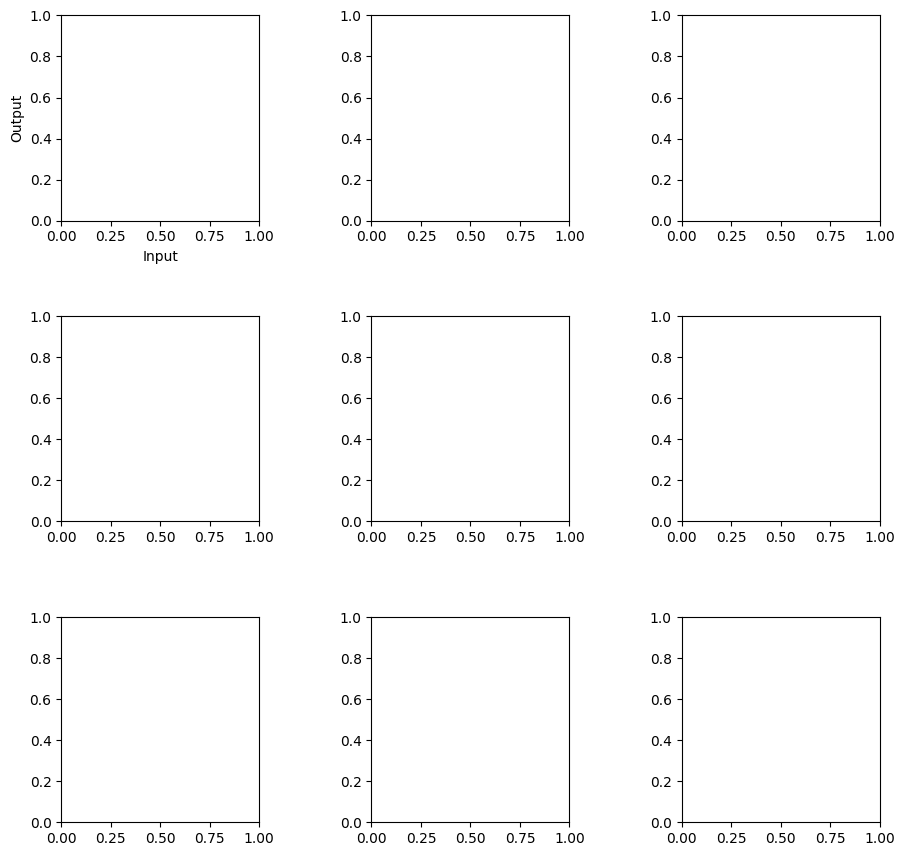

In [53]:



class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout, cell_type, bidirectional=True, batch_size=BATCH_SIZE):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.cell_type = cell_type
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        if cell_type == 'RNN':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        # self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, hidden=None):
        self.batch_size = src.shape[1]
        embedded = self.dropout(self.embedding(src))
        if self.cell_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded,hidden)
        if self.bidirectional:
    # Split hidden and cell into two halves along the first dimension
            hidden_chunks = torch.chunk(hidden, 2, dim=0)
            hidden = 0.5 * (hidden_chunks[0] + hidden_chunks[1])

            if self.cell_type == "LSTM":
                cell_chunks = torch.chunk(cell, 2, dim=0)
                cell = 0.5 * (cell_chunks[0] + cell_chunks[1])

    # Compute the average of forward and backward outputs
            output = output.permute(2, 1, 0)
            output_chunks = torch.chunk(output, 2, dim=0)
            output = 0.5 * (output_chunks[0] + output_chunks[1])
            output = output.permute(2, 1, 0)

        if (self.cell_type == "LSTM"):
            return output, hidden, cell
        else:
            return output, hidden

    def initHidden(self):
        if self.bidirectional == True:
            return torch.zeros(2*self.num_layers, self.batch_size, self.hidden_size, device=device)
        else:
            return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, device=device)

# write decoder with attention


class Decoder_with_attention(nn.Module):
    def __init__(self,hidden_size,output_size,num_layers,dropout,embedding_size, cell_type ="LSTM",batch_size=BATCH_SIZE):
        super(Decoder_with_attention,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.cell_type = cell_type
        self.embedding = nn.Embedding(output_size,embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(self.hidden_size+self.embedding_size,MAX_LENGTH)
        self.attn_combine = nn.Linear(self.hidden_size+self.embedding_size,self.hidden_size)
        self.dropout = nn.Dropout(dropout)
        if cell_type == 'RNN':
            self.rnn = nn.RNN(self.hidden_size,self.hidden_size,num_layers,dropout=dropout)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(self.hidden_size,self.hidden_size,num_layers,dropout=dropout)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(self.hidden_size,self.hidden_size,num_layers,dropout=dropout)

        self.out = nn.Linear(self.hidden_size,self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,input,hidden,encoder_outputs):
    
        input = input.unsqueeze(0)
        self.batch_size = input.size(1)
        output = self.embedding(input).view(-1,self.batch_size,self.embedding_size)
        output = self.dropout(output)
        if self.cell_type == "LSTM":
            attn_weights = F.softmax(self.attn(torch.cat((output[0],hidden[0][0]),1)),dim=1)
        else:
            attn_weights = F.softmax(self.attn(torch.cat((output[0],hidden[0]),1)),dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs.permute(1,0,2))
        attn_applied = attn_applied.squeeze(1)
        # print("attention applied shape",attn_applied.shape)
        output = torch.cat((output[0],attn_applied),1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        if self.cell_type == "LSTM":
            output,(hidden,cell) = self.rnn(output,(hidden[0],hidden[1]))
            return self.out(output[0]),hidden,cell,attn_weights
        else:
            output,hidden = self.rnn(output,hidden)
            return self.out(output[0]),hidden,attn_weights  
        




class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.5,heatmap=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.heatmap = heatmap
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src, trg, heatmap=False):
        attention_weights = []
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_size
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_hidden = self.encoder.initHidden()
        # encoder_hidden = self.encoder.initHidden()
        if self.encoder.cell_type == 'LSTM':
            encoder_output, encoder_hidden, encoder_cell = self.encoder(src,encoder_hidden)
        else:
            encoder_output, encoder_hidden = self.encoder(src,encoder_hidden)
        input_decoder = trg[0, :]
        decoder_hidden = encoder_hidden

        if self.decoder.cell_type == 'LSTM':
            decoder_cell = encoder_cell

        
        for t in range(1, trg_len):
            if self.decoder.cell_type == 'LSTM':
                decoder_output, decoder_hidden, decoder_cell,attn_weights = self.decoder(input_decoder,( decoder_hidden, decoder_cell),encoder_output)

            else:
                decoder_output, decoder_hidden, attn_weights = self.decoder(input_decoder, decoder_hidden,encoder_output)
            # print("attention_weights",attn_weights)
            if(heatmap):
                attention_weights.append(attn_weights)
            outputs[t] = decoder_output
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            input_decoder = trg[t] if teacher_force else top1
        
        return outputs,attention_weights


def get_accuracy(preds, target):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    preds = preds.argmax(dim=2)
    preds = preds[1:]
    target = target[1:]
    matches = torch.eq(preds, target)
    columns_matches = torch.sum(matches, dim=0)
    num_matching_columns = torch.sum(columns_matches == target.shape[0])
    acc = num_matching_columns / target.shape[1]
    return acc.item()


def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    pbar = tqdm(iterator, desc="Training", position=0, leave=True)
    
    for i, (data, target) in enumerate(pbar):
        src = data.to(device)
        trg = target.to(device)
        optimizer.zero_grad()
        output,attn_weights = model(src, trg)
        # print("attention weights", attn_weights)
        # print("attention weights shape", attn_weights.shape)
        # attn_weightscpu = attn_weights.cpu().detach().numpy()
        # sns.heatmap(attn_weightscpu, cmap="YlGnBu", annot=False,fmt='.2f')
        # plt.show()
        output_dim = output.shape[-1]
        output_reshaped = output[1:].reshape(-1, output_dim)
        trg_reshaped = trg[1:].reshape(-1)
        loss = criterion(output_reshaped, trg_reshaped)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        acc = get_accuracy(output, trg)
        epoch_acc += acc
        epoch_loss += loss.item()
        pbar.set_postfix(train_loss=epoch_loss / (i + 1), train_acc=epoch_acc / (i + 1))
        if True:
            break
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname='Mangal 400.TTF')

def plot_attention_heatmap(model,iterator):
    for i, (data, target) in enumerate(iterator):
        src = data.to(device)
        trg = target.to(device)
        #get first 10 examples
        # src = data[:10].to(device)
        # trg = target[:10].to(device)
        output,attention_weights= model(src,trg,heatmap=True)
        # attention_weights = torch.stack(attention_weights).squeeze()  # Convert the list to a tensor
        # attention_weights = torch.cat(attention_weights, dim=0) 
        # attention_weights = torch.stack(attention_weights).squeeze().cpu().detach().numpy()
        attention_weights = torch.stack(attention_weights, dim=0)  # Convert the list to a tensor

        attention_weights = attention_weights.squeeze().cpu().detach().numpy()  # Convert the tensor to a numpy array
        #attention_weights shape = (trg_len, batch_size, src_len)
        # attention_weights.permute(1,0,2)
        attention_weights = attention_weights.transpose(1,0,2)
        # attention_weights shape = (batch_size, trg_len, src_len)
        # print("attention weights shape",attention_weights.shape)
        # print("attention weights",attention_weights)
        #get first 10 examples
        attention_weights = attention_weights[:10]
        #get first 10 examples
        # src shape = (src_len, batch_size)
        src = src.transpose(1,0)
        trg = trg.transpose(1,0)
        src = src[:10]
        trg = trg[:10]


        fig, axes = plt.subplots(3, 3, figsize=(10,10))
        fig.tight_layout(pad=5.0)
        fig.subplots_adjust(top=0.90)
        axes = axes.ravel()

        for j in range(attention_weights.shape[0]):
            output_vs_input_attention = attention_weights[j]
            print("Output_vs_input_attention:", output_vs_input_attention)
            max_src_len = src.shape[1]
            max_trg_len = trg.shape[1]
            for k in range(max_src_len):
                if src[j][k] == 0:
                    max_src_len = k+1
                    break
            
            for k in range(max_trg_len):
                if trg[j][k] == 0:
                    max_trg_len = k+1
                    break
            src = src[j][:max_src_len] 
            trg = trg[j][:max_trg_len]
            print("src", src)
            print("trg", trg)
            output_vs_input_attention = output_vs_input_attention[:max_trg_len, :max_src_len]
            print("output vs intput attention shape", output_vs_input_attention.shape)

            # Plot heatmap
            # heatmap = axes.imshow(output_vs_input_attention, cmap='hot',cbar=False)

            # Set x-axis and y-axis labels
            axes[j].set_xlabel("Input")
            axes[j].set_ylabel("Output")
            # Set x-tick labels and rotate if needed
            input_characters = [INPUT_INDX_CHAR[i] for i in src[j].tolist()]
            output_characters = [OUTPUT_INDEX_CHAR[i] for i in trg[j].tolist()]
            axes[j].set_xticklabels(input_characters, rotation=90)
            
            # Set y-tick labels
            axes[j].set_yticklabels(output_characters, fontproperties = font_prop, fontdict={'fontsize':16})
            sns.heatmap(output_vs_input_attention, cmap="YlGnBu",cbar=False)
            # # Show the colorbar
            # cbar = ax.figure.colorbar(heatmap, ax=ax)

            # Adjust plot layout for better alignment

            
            # if True:
            #     break



        
        fig.tight_layout()

            # Show the plot
        plt.show()


        if True:
            break



def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    # with torch.no_grad():
    for i, (data, target) in enumerate(iterator):
        src = data.to(device)
        trg = target.to(device)
        output, _ = model(src, trg)
        output_dim = output.shape[-1]
        output_reshaped = output[1:].reshape(-1, output_dim)
        trg_reshaped = trg[1:].reshape(-1)
        loss = criterion(output_reshaped, trg_reshaped)
        acc = get_accuracy(output, trg)
        epoch_acc += acc
        epoch_loss += loss.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def predict(model, input_word, actual_output):
    data_pred = [[input_word, actual_output]]
    data_batch = DataLoader(data_pred, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
    iterator = data_batch

    src = data
    trg = target
    output = model(src, trg, 0)
    output_dim = output.shape[-1]
    # output_reshaped = output[1:].reshape(-1, output_dim)
    # trg_reshaped = trg[1:].reshape(-1)
    preds = output.argmax(dim=2)
    print("input word", input_word)
    print("actual word", actual_output)
    predicted_word = ""
    for i in preds:
        if i.item() in [0, 1, 2]:
            continue
        predicted_word += predicted_word + OUTPUT_INDEX_CHAR[i.item()]
    print("predicted word", predicted_word)
    return preds


N_EPOCHS = 1
CLIP = 1
INPUT_DIM = input_vocab_size
OUTPUT_DIM = output_vocab_size
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HIDDEN_SIZE = 256
num_layers = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
TEACHER_FORCING = 0.5
BI_DIRECTION = True
CELL_TYPE = 'LSTM'
pred_src = "$bindya|"
pred_trg = '$बिन्द्या|'
BATCH_SIZE = 32
enc = Encoder(input_size=INPUT_DIM, embedding_size=ENC_EMB_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers,
              dropout=ENC_DROPOUT, cell_type=CELL_TYPE, bidirectional=BI_DIRECTION)
dec = Decoder_with_attention(output_size=OUTPUT_DIM, embedding_size=DEC_EMB_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers,
              dropout=DEC_DROPOUT, cell_type=CELL_TYPE,batch_size=BATCH_SIZE)

model = Seq2Seq(enc, dec, device, teacher_forcing_ratio=TEACHER_FORCING).to(device)


def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
best_valid_loss = float('inf')
gbar = tqdm(range(1, N_EPOCHS + 1), position=1, leave=True, desc='Epochs', total=N_EPOCHS)
for epoch in gbar:
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, CLIP)


    gbar.set_postfix(train_loss=train_loss, train_acc=train_accuracy, val_loss=valid_loss, val_acc=valid_accuracy)

plot_attention_heatmap(model,valid_dataloader)

# predict(model, pred_src, pred_trg)
# predict(model,"$बिन्द्या|","$bindya|")

In [ ]:
print(MAX_LENGTH)

25


In [29]:
sweep_config = {
  "name": "CS6910 Assignment 3",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
        
        "cell_type": {
            "values": ["LSTM","GRU"]
        },
        "bidirectional": {
            "values": [True, False]
        },
        "num_epochs": {
            "values": [20,25]
        },
        "num_layers": {
            "values": [1, 2, 3]
        },
        "batch_size": {
            "values": [32,64,128]
        },
        "embedding_size": {
            "values": [128, 256, 512]
        },
        "hidden_size": {
            "values": [128, 256, 512]
        },
        "learning_rate": {
            "values": [0.001,0.0001]
        },
        "enc_dropout": {
            "values": [0.2,0.3,0.5]
        },
        "dec_dropout": {
            "values": [0.2,0.3,0.5]
        }
    }
}



In [ ]:
def model_train(INPUT_DIM, OUTPUT_DIM, EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS, ENC_DROPOUT, DEC_DROPOUT,  BIDIRECTIONAL, CELL_TYPE, LEARNING_RATE, N_EPOCHS, CLIP,BATCH_SIZE):
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    encoder = Encoder(input_size=INPUT_DIM, embedding_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=ENC_DROPOUT, bidirectional=BIDIRECTIONAL, cell_type=CELL_TYPE)
    decoder = Decoder(output_dim=OUTPUT_DIM, emb_dim=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DEC_DROPOUT, cell_type=CELL_TYPE)
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    # pbar = tqdm(range(N_EPOCHS), desc="Epochs",position=0, leave=True)
    gbar = tqdm(range(1, N_EPOCHS + 1),position=1,leave=True, desc='Epochs', total=N_EPOCHS)
#     gbar = N_EPOCHS
    for epoch in gbar:

        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, clip=CLIP)
        # print(run_name)
        valid_loss, valid_acc = evaluate(model,valid_dataloader, criterion)
        print("Epoch: ",epoch)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')
        wandb.log({"train_loss": train_loss, "train_acc": train_acc, "valid_loss": valid_loss, "valid_acc": valid_acc})
        gbar.set_postfix(train_loss=train_loss, train_acc=train_acc, valid_loss=valid_loss, valid_acc=valid_acc)
    return valid_acc

In [ ]:
def run_wandb():
    wandb.init()
    config = wandb.config
    LEARNING_RATE = config.learning_rate
    BATCH_SIZE = config.batch_size
    EMBEDDING_SIZE = config.embedding_size
    HIDDEN_SIZE = config.hidden_size
    ENC_DROPOUT = config.enc_dropout
    DEC_DROPOUT = config.dec_dropout
    NUM_LAYERS = config.num_layers
    BIDIRECTIONAL = config.bidirectional
    CELL_TYPE = config.cell_type
    N_EPOCHS = config.num_epochs
    CLIP = 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    INPUT_DIM = len(INPUT_CHAR_INDX)
    OUTPUT_DIM = len(OUTPUT_CHAR_INDEX)
    model_train(INPUT_DIM=INPUT_DIM, OUTPUT_DIM=OUTPUT_DIM, EMBEDDING_SIZE=EMBEDDING_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, NUM_LAYERS=NUM_LAYERS, ENC_DROPOUT=ENC_DROPOUT,DEC_DROPOUT=DEC_DROPOUT, BIDIRECTIONAL=BIDIRECTIONAL, CELL_TYPE=CELL_TYPE, LEARNING_RATE=LEARNING_RATE, N_EPOCHS=N_EPOCHS, CLIP=CLIP,BATCH_SIZE=BATCH_SIZE)
    # best_valid_loss = float('inf')
    print("cell_type",CELL_TYPE,"bidirectional",BIDIRECTIONAL,"num_layers",NUM_LAYERS,"batch_size",BATCH_SIZE,"embedding_size",EMBEDDING_SIZE,"hidden_size",HIDDEN_SIZE,"enc_dropout",ENC_DROPOUT,"dec_dropout",DEC_DROPOUT,"num_epochs",N_EPOCHS)
    run_name = "ct_{}_bi_{}_nl_{}_bs_{}_es_{}_hs_{}_endo_{}_decdo_{}_ne_{}".format(CELL_TYPE,BIDIRECTIONAL,NUM_LAYERS,BATCH_SIZE,EMBEDDING_SIZE,HIDDEN_SIZE,ENC_DROPOUT,DEC_DROPOUT,N_EPOCHS)
    print(run_name)
    wandb.run.name = run_name
    wandb.run.save()

In [ ]:
# # wandb.init()
# config=wandb.config
# LEARNING_RATE = 0.001
# BATCH_SIZE = 32
# EMBEDDING_SIZE = 128
# HIDDEN_SIZE = 512
# ENC_DROPOUT = 0.2
# DEC_DROPOUT = 0.2
# NUM_LAYERS = 2
# BIDIRECTIONAL = True
# CELL_TYPE = 'LSTM'
# N_EPOCHS = 1
# CLIP = 1
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
# valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False,     collate_fn=generate_batch)
# INPUT_DIM = len(INPUT_CHAR_INDX)
# OUTPUT_DIM = len(OUTPUT_CHAR_INDEX)
# model_train(INPUT_DIM=INPUT_DIM, OUTPUT_DIM=OUTPUT_DIM, EMBEDDING_SIZE=EMBEDDING_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, NUM_LAYERS=NUM_LAYERS, ENC_DROPOUT=ENC_DROPOUT,DEC_DROPOUT=DEC_DROPOUT, BIDIRECTIONAL=BIDIRECTIONAL, CELL_TYPE=CELL_TYPE, LEARNING_RATE=LEARNING_RATE, N_EPOCHS=N_EPOCHS, CLIP=CLIP,BATCH_SIZE=BATCH_SIZE)
# # best_valid_loss = float('inf')
# # run_name = "ct_{}_bi_{}_nl_{}_bs_{}_es_{}_hs_{}_do_{}_ne{}".format(CELL_TYPE,BIDIRECTIONAL,NUM_LAYERS,BATCH_SIZE,EMBEDDING_SIZE,HIDDEN_SIZE,DROPOUT,N_EPOCHS)
# # print(run_name)

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="cs22m045", project="DL_ASSIGNMENT_3")
wandb.agent(sweep_id,run_wandb, count=50)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: x2ojhehe
Sweep URL: https://wandb.ai/cs22m045/DL_ASSIGNMENT_3/sweeps/x2ojhehe


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run graceful-meadow-11 at: https://wandb.ai/cs22m045/DL_ASSIGNMENT_3/runs/n92g2j3z
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230516_071553-n92g2j3z/logs
wandb: Agent Starting Run: as4hm8y3 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_dropout: 0.5
wandb: 	embedding_size: 128
wandb: 	enc_dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 15
wandb: 	num_layers: 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 1.267 | Train Acc: 0.00%
	 Val. Loss: 0.873 |  Val. Acc: 0.02%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 1.013 | Train Acc: 0.03%
	 Val. Loss: 0.723 |  Val. Acc: 0.59%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.849 | Train Acc: 0.22%
	 Val. Loss: 0.576 |  Val. Acc: 1.98%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.715 | Train Acc: 1.16%
	 Val. Loss: 0.475 |  Val. Acc: 5.27%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.613 | Train Acc: 2.88%
	 Val. Loss: 0.412 |  Val. Acc: 8.96%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.550 | Train Acc: 4.52%
	 Val. Loss: 0.381 |  Val. Acc: 11.43%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.503 | Train Acc: 6.20%
	 Val. Loss: 0.361 |  Val. Acc: 14.29%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.470 | Train Acc: 7.91%
	 Val. Loss: 0.349 |  Val. Acc: 15.04%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.445 | Train Acc: 9.28%
	 Val. Loss: 0.328 |  Val. Acc: 17.04%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.424 | Train Acc: 10.36%
	 Val. Loss: 0.314 |  Val. Acc: 17.68%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.406 | Train Acc: 11.70%
	 Val. Loss: 0.306 |  Val. Acc: 18.61%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.392 | Train Acc: 12.78%
	 Val. Loss: 0.292 |  Val. Acc: 20.49%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.379 | Train Acc: 13.79%
	 Val. Loss: 0.288 |  Val. Acc: 20.17%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

	Train Loss: 0.369 | Train Acc: 14.61%
	 Val. Loss: 0.282 |  Val. Acc: 20.98%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


	Train Loss: 0.361 | Train Acc: 15.59%
	 Val. Loss: 0.277 |  Val. Acc: 21.90%
ct_LSTM_bi_False_nl_1_bs_64_es_128_hs_128_endo_0.5_decdo_0.5_ne_15


train_acc,▁▁▁▂▂▃▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
valid_acc,▁▁▂▃▄▅▆▆▆▇▇█▇██
valid_loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁
train_acc,0.15588
train_loss,0.36053
valid_acc,0.21904
valid_loss,0.27669


Error in callback <function _WandbInit._pause_backend at 0x786e3559fe20> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:

# N_EPOCHS = 1
# CLIP = 1
# INPUT_DIM = input_vocab_size
# OUTPUT_DIM = output_vocab_size
# ENC_EMB_DIM = 128
# DEC_EMB_DIM = 128
# HIDDEN_SIZE = 256
# num_layers = 1
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5
# TEACHER_FORCING = 0.5
# BI_DIRECTION = True
# CELL_TYPE = 'LSTM'
# pred_src = "$bindya|"
# pred_trg = '$बिन्द्या|'

# enc = Encoder(input_size=INPUT_DIM, embedding_size=ENC_EMB_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, dropout=ENC_DROPOUT, cell_type=CELL_TYPE, bidirectional=BI_DIRECTION)
# dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, hidden_size=HIDDEN_SIZE, num_layers=num_layers, dropout=DEC_DROPOUT, cell_type=CELL_TYPE, bidirectional=BI_DIRECTION)

# model = Seq2Seq(enc, dec, device, teacher_forcing_ratio=TEACHER_FORCING).to(device)
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param.data, -0.08, 0.08)


# model.apply(init_weights)
# optimizer = optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()

# best_valid_loss = float('inf')
# gbar = tqdm(range(1, N_EPOCHS + 1),position=1,leave=True, desc='Epochs', total=N_EPOCHS)
# for epoch in gbar:
#     train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, CLIP)
#     valid_loss, valid_accuracy = evaluate(model, valid_dataloader, criterion)
#     gbar.set_postfix(train_loss=train_loss, train_acc=train_accuracy, val_loss=valid_loss, val_acc=valid_accuracy)

Error in callback <function _WandbInit._resume_backend at 0x786e3559fd90> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <function _WandbInit._pause_backend at 0x786e3559fe20> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe